# Linear Regression

### Imports

In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics


import pickle

### Read in Data

Removing `car_body` and `car_engine` columns. 

As one would expect the values in these columns are almost perfectly correlated to the `model` and `trim` columns, respectively. Removing these columns has little effect on the quality of the predictive model and makes the final Streamlit app more user friendly, due to fewer required user inputs.

In [254]:
df = pd.read_csv('../datasets/cazoo_cleaned.csv')
df.drop(columns = ['car_body', 'car_engine'], inplace= True)
df.head()

,model,listing_price,trim,mileage,transmission,color,car_make,car_age
0,Q7,57500,3L Black Edition TDI V6,12997,Automatic,Grey,Audi,1.0
1,Macan,57000,2L T,4706,Automatic,Silver,Porsche,2.0
2,Macan,56350,3L S T V6,4605,Automatic,Grey,Porsche,2.0
3,Model 3,55900,Long Range,1614,Automatic,White,Tesla,1.0
4,Range Rover Sport,55550,3L Autobiography Dynamic SD V6,26375,Automatic,Grey,Land Rover,4.0


#### Preparing Features and Target Variable

The categorical features in the model are encoded, dummified and then concatenated alongside the numeric features in the model. It will be essential that the inputs from the Streamlit app are organised in the same order as the new concatenated dataframe so the predictive model can accurately run.

The one-hot encoding is then pickled.

In [255]:
# Split and Prepare the Categorical and Numerical Features 
categorical_features = df.select_dtypes([object])
categorical_feature_names = categorical_features.dtypes.keys()
numerical_features = df.select_dtypes(exclude=object)

# One Hot Encode Categorical Features
enc = OneHotEncoder(sparse=False)
categorical_features_enc = enc.fit_transform(categorical_features) 
dummy_category_names = enc.get_feature_names(categorical_feature_names)

# Create a dataframe with all new dummified categorical features
categorical_feature_df = pd.DataFrame(categorical_features_enc, columns=dummy_category_names)

# Concatenate the Numerical features with the dummified Categorical features
df = pd.concat([numerical_features, categorical_feature_df], axis=1)

# One-hot encoding model is then pickled
pickle.dump(enc, open('../app/model/input_encoder.pkl','wb'))

/Users/giovanniceretti/miniforge3/envs/dsi/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [256]:
X = df.drop(columns=['listing_price'])
y = df['listing_price']

# Modeling

### Calculating Null Model Metrics

#### Mean Squared Error

In [257]:
y_bar = np.mean(y)
null_mse = np.mean((y - y_bar) ** 2)
null_mse

48556014.43598784

#### Root Mean Squared Error

In [258]:
null_rmse = null_mse ** .5
null_rmse

6968.214580219803

#### Mean Absolute Error

In [259]:
absolute_error = 0
for i in range(1, len(y)):
    absolute_error += abs(y[i] - y_bar)
    
absolute_error / (len(y))

5368.040690713771

### Initial Linear Regression

Initial Linear Regression using no Feature Engineering or feature Scaling.

The Mean Squared Error from the initial linear regression model shows an immense improvement on the null model.

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 88)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Test R-Squared: {lr.score(X_test, y_test)}')

y_preds = lr.predict(X_test)
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_preds)}')
MAE = metrics.mean_absolute_error(y_test, y_preds)
print(f'Mean Absolute Error: {MAE}')

Training R-Squared: 0.9794585412716708
Test R-Squared: 0.9383700875496879
Mean Squared Error: 2683251.795127452
Mean Absolute Error: 1019.6144990999414


### Log Transformation on the `listing_price` target variable

Using a Log Transformation on the `listing_price` target variable led to a materially better R-Squared test statistic. Moving forward, the `log_listing_price` column will be used as the target variable.

In [261]:
df_log = df.copy()

df_log['log_listing_price'] = np.log(df_log['listing_price'])

X = df_log.drop(columns=['listing_price', 'log_listing_price'])
y = df_log['log_listing_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 88)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Test R-Squared: {lr.score(X_test, y_test)}')

y_preds = lr.predict(X_test)
MSE = metrics.mean_squared_error(np.exp(y_test), np.exp(y_preds))
print(f'Mean Squared Error: {MSE}')
MAE = metrics.mean_absolute_error(np.exp(y_test), np.exp(y_preds))
print(f'Mean Absolute Error: {MAE}')

Training R-Squared: 0.9861370504090744
Test R-Squared: 0.9591331307528751
Mean Squared Error: 1917700.9249655493
Mean Absolute Error: 872.4291169304652


#### Updating Primary Dataframe to include the Log Transformed Target Variable

In [262]:
df['log_listing_price'] = np.log(df['listing_price'])
df.head()

,listing_price,mileage,car_age,model_1 Series,model_108,model_124 Spider,model_2 Series,model_2 Series Active Tourer,model_2 Series Gran Tourer,model_2008,...,car_make_Skoda,car_make_Smart,car_make_Ssangyong,car_make_Suzuki,car_make_Tesla,car_make_Toyota,car_make_Vauxhall,car_make_Volkswagen,car_make_Volvo,log_listing_price
0,57500,12997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.959540
1,57000,4706,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.950807
2,56350,4605,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.939338
3,55900,1614,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.931320
4,55550,26375,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.925039


### Linear Regression with Feature Engineering on `car_age` & `mileage` columns

This dataframe had two numerical features which could be leveraged to create new features to improve the predictive capabilities of the model.

Three feature engineering efforts were tried:
1. Scaling the `car_age` column by raising the column values to the power of certain inputs.
    - With trial and error it was idenfied that the input power that generated the best R-Squared test statistic was the square root of the `car_age`
2. Scaling the `mileage` column by putting the column values to the power of certain inputs.
    - With trial and error it was idenfied that the power that generated the best R-Squared test statistic was the square root of the `mileage`
3. The creation of a `miles_per_year` column to identify miles driven per year for each listing.

The results of these efforts showed that a model with only the `car_age` feature scaled produced the highest R-Squared test statistic and lowest Mean Squared Error statistic. Therefore moving forward, this engineered feature will be included.

#### Model with `car_age` Feature Engineering

In [263]:
df_feat_eng = df.copy()

df_feat_eng['car_age'] = df_feat_eng['car_age'] ** .5

X = df_feat_eng.drop(columns=['listing_price', 'log_listing_price'])
y = df_feat_eng['log_listing_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 88)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Test R-Squared: {lr.score(X_test, y_test)}')

y_preds = lr.predict(X_test)
MSE = metrics.mean_squared_error(np.exp(y_test), np.exp(y_preds))
print(f'Mean Squared Error: {MSE}')
MAE = metrics.mean_absolute_error(np.exp(y_test), np.exp(y_preds))
print(f'Mean Absolute Error: {MAE}')

Training R-Squared: 0.985806922021318
Test R-Squared: 0.9602618173621087
Mean Squared Error: 1853225.726591467
Mean Absolute Error: 867.7001607331606


#### Updating the final model dataframe to include the feature change

In [264]:
df['car_age'] = df['car_age'] ** .5
df.rename(columns={"car_age": "car_age_sqrt"}, inplace = True)

# Model Analysis

### Interpretting the Model Results

##### `listing_price` Column statistics

- Standard Deviation: £6,968<br>
- Mean: £17,346<br>
- Median: £15,550<br>

##### Null Model Metrics

- Null Model Mean Squared Error: £48,556,014<br>
- Null Model Root Mean Squared Error: £6,968<br>
- Null Model Mean Absolute Error: £5,368

##### Best Performing Predictive Model Metrics

- Model MSE: £1,853,225<br>
- Model RMSE: £1,361<br>
- Model MAE: £867

The best performing predictive model shows a material improvement to the null model. RMSE and MAE statistics showed an improvement of 80% and 84%, respectively.

The model's MAE is equal to 1/8th of the standard deviation of the listing prices, which underlines the model's high predciitve capacity.

In [265]:
df['listing_price'].describe()

count     6909.000000
mean     17345.599942
std       6968.718920
min       5700.000000
25%      12350.000000
50%      15550.000000
75%      21050.000000
max      57500.000000
Name: listing_price, dtype: float64

### Predicted vs True Listing Price Plot

The plot below shows that the model is adept at predicting the listing prices of cars with a value of less than £30,000. If the model has to predict the listing price of more valuable, its predictions are not as strong.

This should still be considered an excellent result as 95% of cars from the dataset had a listing price of less than £30,000.

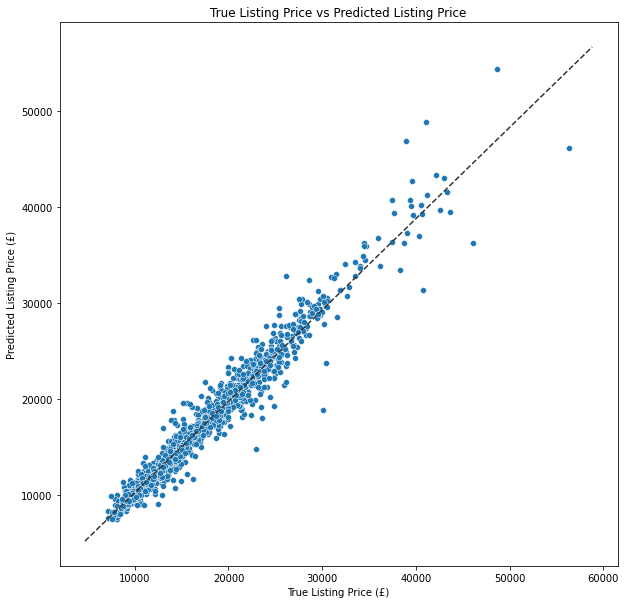

In [266]:
plt.figure(figsize = (10, 10))
p = sns.scatterplot(x = np.exp(y_test),
        y = np.exp(lr.predict(X_test)));
p.set_title('True Listing Price vs Predicted Listing Price')
p.set_xlabel("True Listing Price (£)")
p.set_ylabel("Predicted Listing Price (£)")
p.plot(p.get_xlim(), p.get_ylim(), ls="--", c=".2");
plt.savefig('../images/predicted_vs_true_listing_price.png')

#### Percentile Rank of a `listing_price` of £30,000

In [267]:
stats.percentileofscore(df['listing_price'], 30000, kind='rank')

94.96309161962657

### Analysis of Residuals

From the plots below we can see that the model is more likely to predict a listing price greater than the actual listing price.

Furthermore, the above statement on the model being a better predicter of listing prices of lower value car is confirmed by the plot plotting residuals vs listing price predictions. In this plot, you can see greater bunching around the zero residual line amongst the lower listing price vehicles.

In [268]:
y_preds = np.exp(lr.predict(X_test))
y_test = np.exp(y_test)
residuals = y_test - y_preds

#### Histogram of Residuals

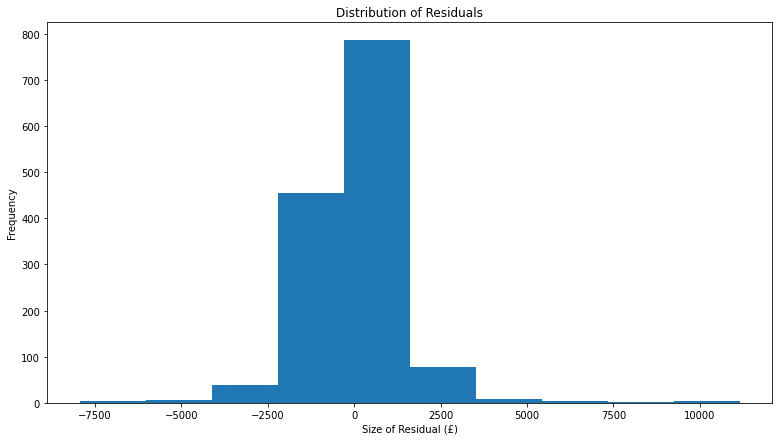

In [269]:
plt.figure(figsize = (13, 7))
plt.title('Distribution of Residuals')
plt.xlabel("Size of Residual (£)")
plt.ylabel("Frequency")
plt.hist(residuals, bins = 10);
plt.savefig('../images/res_dist.png', transparent=True, bbox_inches='tight')
plt.show()

#### Plot of Residuals vs Listing Price Predictions

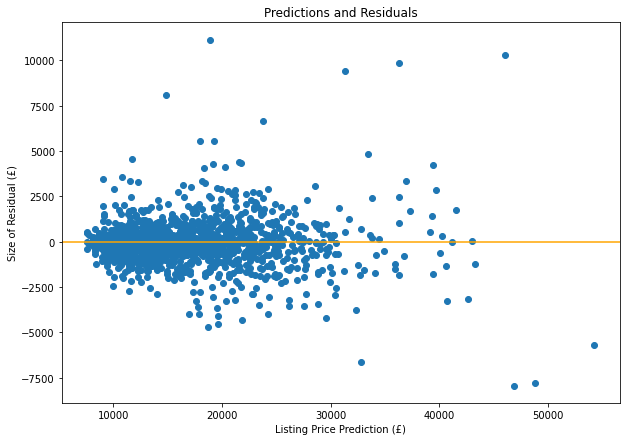

In [270]:
plt.figure(figsize = (10, 7))
plt.scatter(y_preds, residuals)
plt.title('Predictions and Residuals')
plt.xlabel("Listing Price Prediction (£)")
plt.ylabel("Size of Residual (£)")
plt.axhline(0, color = 'orange');
plt.savefig('../images/res_var.png', transparent=True, bbox_inches='tight')
plt.show()

# Pickling

### Pickling the Predictive Model

In [271]:
X = df.drop(columns=['listing_price', 'log_listing_price'])
y = df['log_listing_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 88)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [272]:
with open('../app/model/cazoo_streamlit.pkl', 'wb') as f:
    pickle.dump(lr, f)

### Pickling the Features for Streamlit App Inputs

Creating a dictionary connecting Car Make & Car Model and Car Model and Trim. This will allow the Streamlit to have a dependent drop down menu.

Sorting the feature lists so that they show up alphabetically on the app.

In [273]:
pkld_df = pd.read_csv('./../datasets/cazoo_cleaned.csv')
make_model_dict = pkld_df.groupby('car_make')['model'].unique().agg(list).to_dict()
model_trim_dict = pkld_df.groupby('model')['trim'].unique().agg(list).to_dict()

In [274]:
pickle.dump(make_model_dict, open('../app/model/make_model_dict.pkl','wb'))
pickle.dump(model_trim_dict, open('../app/model/model_trim_dict.pkl','wb'))
pickle.dump(sorted(pkld_df['transmission'].unique()), open('../app/model/transmission_list.pkl','wb'))
pickle.dump(sorted(pkld_df['color'].unique()), open('../app/model/color_list.pkl','wb'))